In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="3"

Sun Jan 14 04:21:29 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:1B:00.0 Off |                    0 |
| 37%   65C    P2   217W / 230W |  16686MiB / 23028MiB |     88%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A5000    Off  | 00000000:1C:00.0 Off |                  Off |
| 42%   

### Model Parts

In [3]:
from model.main.enc_latent_dec import Model
from model.encoder.conv2d_encoder import Encoder
from model.latent_layer.random_sigma_uniform_lse_latent_layer import LatentLayer
from model.decoder.conv2d_decoder import Decoder

from tensorboardX import SummaryWriter
from util.util import *


### Model Init.

In [4]:
from easydict import EasyDict
hp = EasyDict()
hp.size = 64
hp.in_dim = 1
hp.out_dim = 1
hp.z_dim = 2
hp.h_dims = [32, 64, 128, 256, 512]

In [5]:
step = 0
device = 'cuda:0'

model = Model(Encoder(**hp), LatentLayer(**hp), Decoder(**hp))
model = model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

for name, module in model.named_modules():
    if len(name.split('.')) <= 2 and len(name) > 0:
        print(name, get_size(module))
        
print('done')

encoder 6.004646301269531
encoder.convs 5.989013671875
encoder.linear 0.01563262939453125
latent_layer 0.0
decoder 6.044322967529297
decoder.linear 0.0234375
decoder.convs 5.9820556640625
decoder.out_conv 0.038829803466796875
done


### Load

In [6]:
save_dir = '/data/scpark/save/lse/train01.11-12/'
!mkdir -p $save_dir
!ls -lt $save_dir

writer = SummaryWriter(save_dir)

if False:
    step, net_g, _, opt_g, _ = load(save_dir, 0, model, optimizer)

total 38496
-rw-rw-r-- 1 scpark scpark     4172  1월 14 04:21 events.out.tfevents.1705173680.GPUSVR01
-rw-rw-r-- 1 scpark scpark 37973949  1월 14 04:21 save_0
-rw-rw-r-- 1 scpark scpark   753092  1월 14 04:21 events.out.tfevents.1705173299.GPUSVR01
-rw-rw-r-- 1 scpark scpark   683678  1월 14 04:14 events.out.tfevents.1705172953.GPUSVR01


### Dataset

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Transformations applied on each image
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize the image to 32x32
    transforms.ToTensor(),         # Convert the image to a PyTorch tensor
    transforms.Normalize((0.5), (0.5)) 
])

# Load the MNIST dataset
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(mnist_trainset, batch_size=128, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=2048, shuffle=True)
print('done')

done


### Preprocess

In [8]:
def preprocess(batch):
    x, t = batch
    data = {}
    data['x'] = x.to(device)
    data['t'] = t.to(device)
    return data

### Train

In [9]:
def plot(x):
    _x = x.data.cpu().numpy()
    plt.figure(figsize=[18, 4])
    for i in range(10):
        plt.subplot(1, 10, i+1)
        plt.imshow(_x[i, 0])
        plt.xticks([])
        plt.yticks([])
    plt.show()
    
# borrowed from https://gist.github.com/jakevdp/91077b0cae40f8f8244a
def discrete_cmap(N, base_cmap=None):
    """Create an N-bin discrete colormap from the specified input map"""

    # Note that if base_cmap is a string or None, you can simply do
    #    return plt.cm.get_cmap(base_cmap, N)
    # The following works for string, None, or a colormap instance:

    base = plt.cm.get_cmap(base_cmap)
    color_list = base(np.linspace(0, 1, N))
    cmap_name = base.name + str(N)
    return base.from_list(cmap_name, color_list, N)


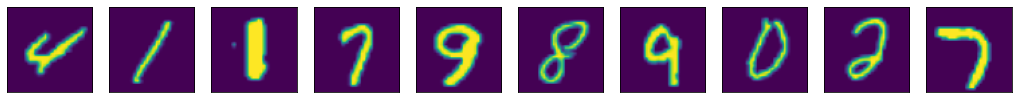

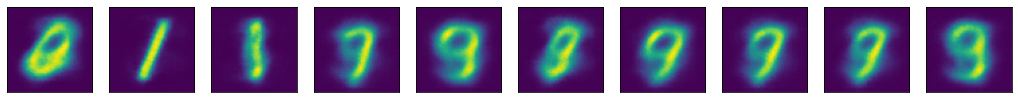

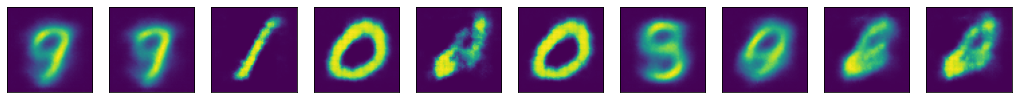

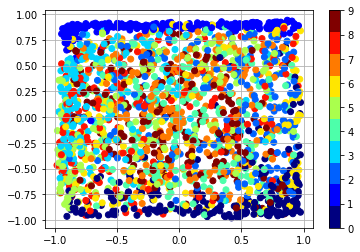

3001
lse_loss -0.8808364868164062
recon_loss 0.17895202338695526
3002
lse_loss -1.2396893501281738
recon_loss 0.16352953016757965
3003
lse_loss -0.7602219581604004
recon_loss 0.16298021376132965
3004
lse_loss -1.2685317993164062
recon_loss 0.17509417235851288
3005
lse_loss -1.2516379356384277
recon_loss 0.17826223373413086
3006
lse_loss -1.168900966644287
recon_loss 0.16964785754680634
3007
lse_loss -1.207550048828125
recon_loss 0.17241951823234558
3008
lse_loss -1.246187686920166
recon_loss 0.162261962890625
3009
lse_loss -0.5174837112426758
recon_loss 0.16380628943443298
3010
lse_loss -1.0773735046386719
recon_loss 0.16511142253875732
3011
lse_loss -1.2774276733398438
recon_loss 0.1818659007549286
3012
lse_loss -1.2545428276062012
recon_loss 0.17018279433250427
3013
lse_loss -1.2129597663879395
recon_loss 0.17883345484733582
3014
lse_loss -1.247704029083252
recon_loss 0.1790834665298462
3015
lse_loss -0.6337070465087891
recon_loss 0.17803990840911865
3016
lse_loss -1.213066577911377


3131
lse_loss -1.174159049987793
recon_loss 0.16844265162944794
3132
lse_loss -1.2724027633666992
recon_loss 0.1740589141845703
3133
lse_loss -0.6963601112365723
recon_loss 0.17153429985046387
3134
lse_loss -1.1827492713928223
recon_loss 0.17735180258750916
3135
lse_loss -1.2647247314453125
recon_loss 0.18178901076316833
3136
lse_loss -1.265681266784668
recon_loss 0.17020630836486816
3137
lse_loss -0.8885912895202637
recon_loss 0.1691502332687378
3138
lse_loss -1.0736432075500488
recon_loss 0.17427031695842743
3139
lse_loss -1.230179786682129
recon_loss 0.1728789508342743
3140
lse_loss -1.274507999420166
recon_loss 0.17611151933670044
3141
lse_loss -1.112597942352295
recon_loss 0.17933353781700134
3142
lse_loss -0.7461981773376465
recon_loss 0.17162394523620605
3143
lse_loss -1.236804485321045
recon_loss 0.16904699802398682
3144
lse_loss -1.2027173042297363
recon_loss 0.175874263048172
3145
lse_loss -1.208395004272461
recon_loss 0.17801424860954285
3146
lse_loss -1.2083549499511719
rec

3261
lse_loss -1.1978187561035156
recon_loss 0.1771290898323059
3262
lse_loss -0.7521018981933594
recon_loss 0.17666535079479218
3263
lse_loss -1.197497844696045
recon_loss 0.18328475952148438
3264
lse_loss -1.0699834823608398
recon_loss 0.170630544424057
3265
lse_loss -1.2876324653625488
recon_loss 0.1724666804075241
3266
lse_loss -1.2384467124938965
recon_loss 0.1688229739665985
3267
lse_loss -1.2181639671325684
recon_loss 0.17092923820018768
3268
lse_loss -1.1560254096984863
recon_loss 0.17984847724437714
3269
lse_loss -1.240422248840332
recon_loss 0.1698320358991623
3270
lse_loss -1.1380624771118164
recon_loss 0.16772249341011047
3271
lse_loss -1.0087480545043945
recon_loss 0.1816781759262085
3272
lse_loss -1.2319855690002441
recon_loss 0.17505303025245667
3273
lse_loss -0.7000851631164551
recon_loss 0.17593470215797424
3274
lse_loss -1.259660243988037
recon_loss 0.1687643826007843
3275
lse_loss -1.200981616973877
recon_loss 0.16874127089977264
3276
lse_loss -1.0669937133789062
rec

3391
lse_loss -0.857757568359375
recon_loss 0.1726740598678589
3392
lse_loss -1.2798547744750977
recon_loss 0.18004736304283142
3393
lse_loss -0.7197933197021484
recon_loss 0.1688610315322876
3394
lse_loss -1.1486506462097168
recon_loss 0.17443302273750305
3395
lse_loss -1.155879020690918
recon_loss 0.16439789533615112
3396
lse_loss -1.1676039695739746
recon_loss 0.1763635277748108
3397
lse_loss -1.1111912727355957
recon_loss 0.16727446019649506
3398
lse_loss -1.2785892486572266
recon_loss 0.1772436797618866
3399
lse_loss -1.2405238151550293
recon_loss 0.17831431329250336
3400
lse_loss -1.16148042678833
recon_loss 0.18059641122817993
3401
lse_loss -1.262723445892334
recon_loss 0.17335575819015503
3402
lse_loss -0.7013425827026367
recon_loss 0.17161151766777039
3403
lse_loss -1.2512640953063965
recon_loss 0.1751573383808136
3404
lse_loss -0.5476322174072266
recon_loss 0.17063909769058228
3405
lse_loss -1.2376255989074707
recon_loss 0.16405794024467468
3406
lse_loss -0.7983136177062988
r

3521
lse_loss -1.283118724822998
recon_loss 0.1736190766096115
3522
lse_loss -1.2048254013061523
recon_loss 0.16896985471248627
3523
lse_loss -1.0819382667541504
recon_loss 0.17332778871059418
3524
lse_loss -1.166956901550293
recon_loss 0.17647670209407806
3525
lse_loss -0.9819307327270508
recon_loss 0.17154940962791443
3526
lse_loss -1.1230902671813965
recon_loss 0.1713905930519104
3527
lse_loss -0.9090123176574707
recon_loss 0.1706465184688568
3528
lse_loss -1.1769623756408691
recon_loss 0.1772002875804901
3529
lse_loss -1.1286630630493164
recon_loss 0.1782536506652832
3530
lse_loss -1.2750396728515625
recon_loss 0.18296609818935394
3531
lse_loss -1.1849899291992188
recon_loss 0.1729600727558136
3532
lse_loss -1.1958532333374023
recon_loss 0.17111502587795258
3533
lse_loss -0.9905095100402832
recon_loss 0.1804254651069641
3534
lse_loss -1.0149855613708496
recon_loss 0.16286587715148926
3535
lse_loss -1.246518611907959
recon_loss 0.1667262762784958
3536
lse_loss -1.1446661949157715
re

3651
lse_loss -1.2333197593688965
recon_loss 0.17526087164878845
3652
lse_loss -1.2272100448608398
recon_loss 0.1649819165468216
3653
lse_loss -1.124621868133545
recon_loss 0.16933730244636536
3654
lse_loss -1.2925915718078613
recon_loss 0.18152257800102234
3655
lse_loss -1.2165632247924805
recon_loss 0.17081499099731445
3656
lse_loss -0.9955549240112305
recon_loss 0.17470774054527283
3657
lse_loss -1.2089924812316895
recon_loss 0.15835468471050262
3658
lse_loss -0.7535829544067383
recon_loss 0.16650423407554626
3659
lse_loss -1.24180269241333
recon_loss 0.17216920852661133
3660
lse_loss -1.198777198791504
recon_loss 0.1716882437467575
3661
lse_loss -1.200911045074463
recon_loss 0.17066851258277893
3662
lse_loss -0.878237247467041
recon_loss 0.171321302652359
3663
lse_loss -1.2354564666748047
recon_loss 0.17933814227581024
3664
lse_loss -1.173327922821045
recon_loss 0.1730440855026245
3665
lse_loss -1.2796964645385742
recon_loss 0.1715364158153534
3666
lse_loss -1.2323389053344727
reco

3781
lse_loss -1.2456049919128418
recon_loss 0.17027458548545837
3782
lse_loss -1.0465760231018066
recon_loss 0.17407700419425964
3783
lse_loss -1.1114354133605957
recon_loss 0.17608001828193665
3784
lse_loss -0.6997852325439453
recon_loss 0.18244151771068573
3785
lse_loss -1.2324671745300293
recon_loss 0.17253771424293518
3786
lse_loss -0.39642906188964844
recon_loss 0.1680164933204651
3787
lse_loss -1.1160311698913574
recon_loss 0.164629727602005
3788
lse_loss -0.8626065254211426
recon_loss 0.17426232993602753
3789
lse_loss -1.278496265411377
recon_loss 0.17417502403259277
3790
lse_loss -1.218858242034912
recon_loss 0.17276321351528168
3791
lse_loss -1.208603858947754
recon_loss 0.1738230437040329
3792
lse_loss -1.235121250152588
recon_loss 0.17818915843963623
3793
lse_loss -0.8405704498291016
recon_loss 0.17509931325912476
3794
lse_loss -0.6135516166687012
recon_loss 0.16568218171596527
3795
lse_loss -1.0398931503295898
recon_loss 0.17246267199516296
3796
lse_loss -0.884824275970459

In [ ]:
from IPython import display

while True:
    for batch in train_loader:
        print(step)
        
        data = preprocess(batch)
        
        # Forward
        model.train()
        model.zero_grad()
        data = model(data, M=1000)
        
        # Backward
        loss = 0
        for key in data.keys():
            if 'loss' in key:
                loss = loss + data[key]
                writer.add_scalar(key, data[key].item(), step)
                print(key, data[key].item())
        loss.backward()
        optimizer.step()
        
        if step % 1000 == 0:
            import matplotlib.pyplot as plt
            display.clear_output()
            
            batch = next(iter(test_loader))
            data = preprocess(batch)
            
            model.eval()
            with torch.no_grad():
                data = model(data, M=1000)
            
            plot(data['x'])
            plot(data['y'])
            
            with torch.no_grad():
                z = torch.randn(10, hp.z_dim).to(device)
                y = model.sample(z)
                plot(y)
                
            import matplotlib.pyplot as plt
            _z = data['z'].data.cpu().numpy()
            plt.scatter(_z[:, 0], _z[:, 1], c=data['t'].data.cpu().numpy(), cmap=discrete_cmap(10, 'jet'))
            plt.grid()
            plt.colorbar()
            plt.show()
        
        if step % 10000 == 0:
            save(save_dir, step, model, optimizer)
                
        step += 1
        